In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_name = "/content/drive/Othercomputers/My Laptop/Water Usage Pattern/data/Potable_water_consumption_by_suburb_2018-2024.csv"

# Read dataset
df = pd.read_csv(file_name)

In [3]:
# Convert wide format to long format for easier plotting
df_melted = df.melt(id_vars=["Name", "Shape__Area"], var_name="Year", value_name="Water_Consumption")

# Convert 'Year' column to actual years (e.g., 'F2005_06' → 2005)
df_melted["Year"] = df_melted["Year"].str.extract(r'F(\d{4})').astype(float)

# Set Seaborn style
sns.set_style("whitegrid")

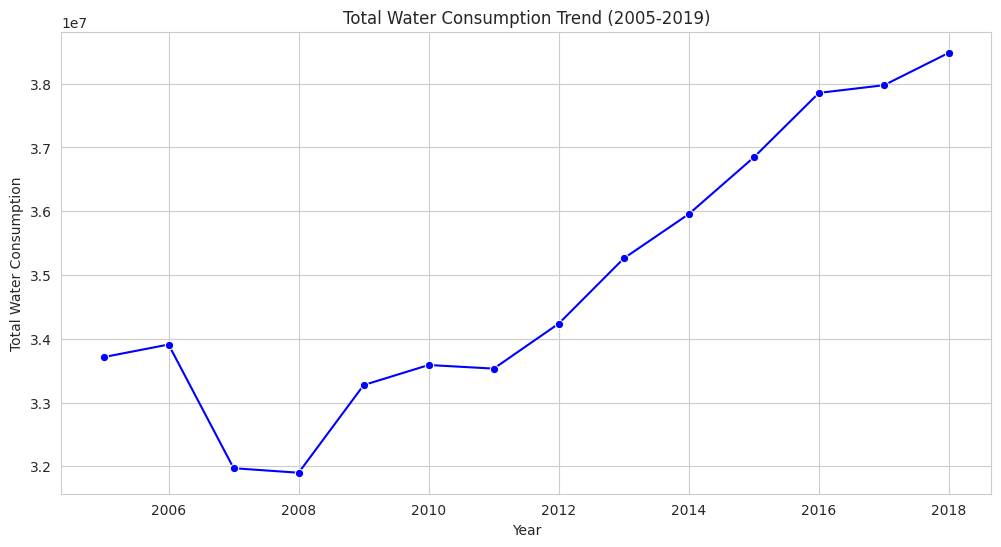

In [4]:
# --- 1. Overall Water Consumption Trend ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted, x="Year", y="Water_Consumption", estimator="sum", errorbar=None, marker="o", color="b")
plt.title("Total Water Consumption Trend (2005-2019)")
plt.xlabel("Year")
plt.ylabel("Total Water Consumption")
plt.grid(True)
plt.show()

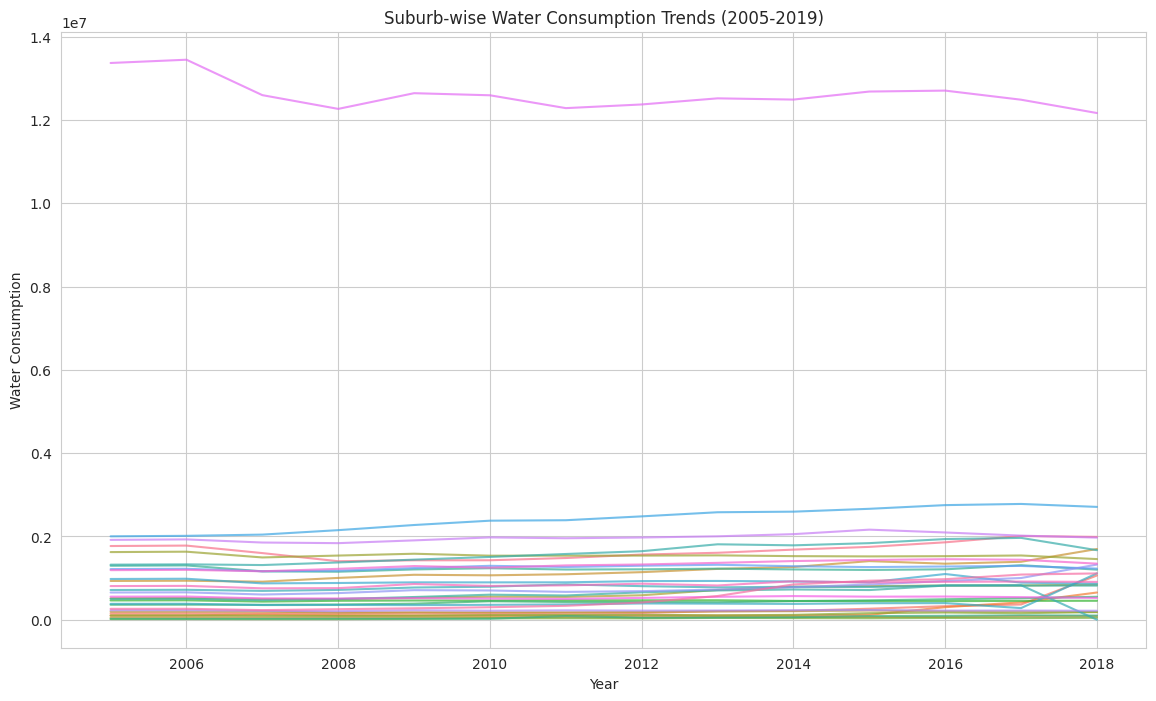

In [5]:
# --- 2. Suburb-wise Water Consumption Trends ---
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_melted, x="Year", y="Water_Consumption", hue="Name", alpha=0.7, legend=False)
plt.title("Suburb-wise Water Consumption Trends (2005-2019)")
plt.xlabel("Year")
plt.ylabel("Water Consumption")
plt.grid(True)
plt.show()

<ipython-input-6-29da0331c8f7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=suburb_avg.values, y=suburb_avg.index, palette="coolwarm")


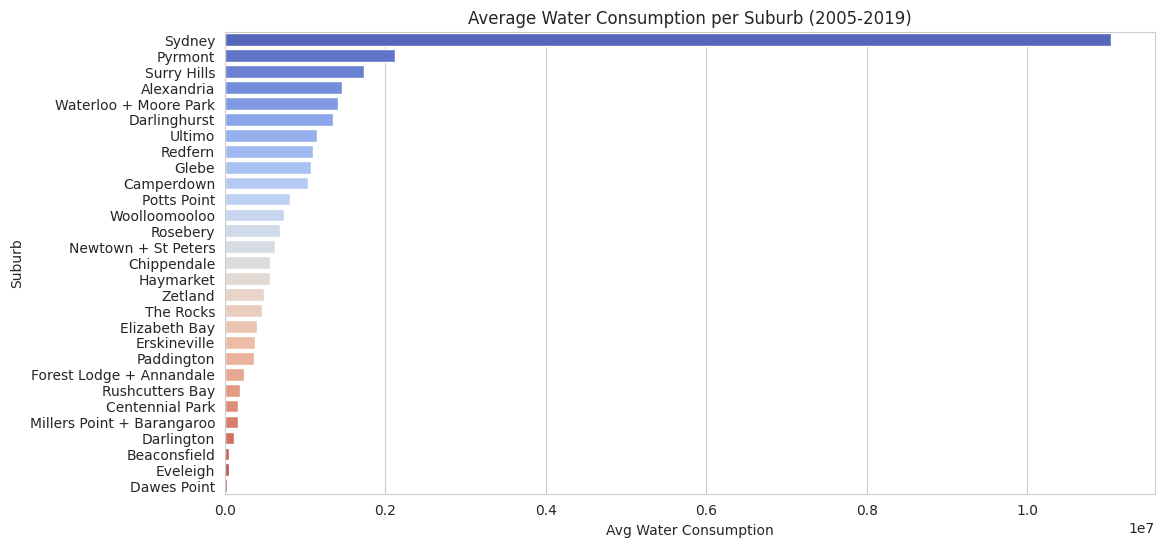

In [6]:
# --- 3. Identify High vs. Low Water Usage Suburbs ---
suburb_avg = df_melted.groupby("Name")["Water_Consumption"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=suburb_avg.values, y=suburb_avg.index, palette="coolwarm")
plt.title("Average Water Consumption per Suburb (2005-2019)")
plt.xlabel("Avg Water Consumption")
plt.ylabel("Suburb")
plt.show()

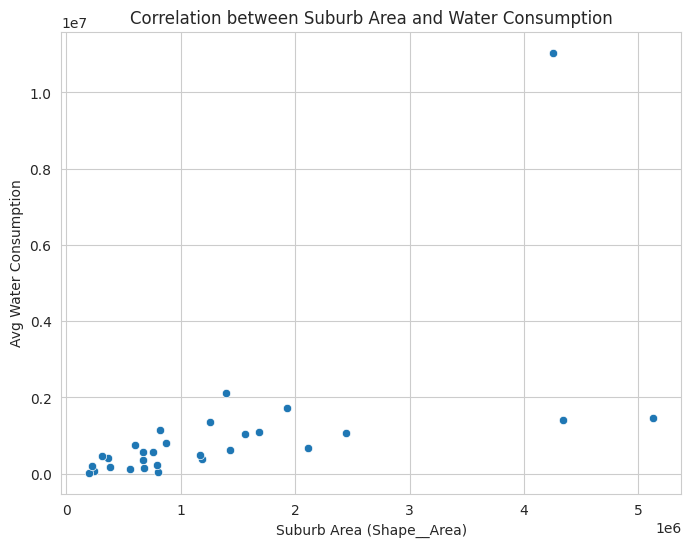

In [7]:
# --- 4. Correlation between Suburb Area and Water Consumption ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_melted.groupby("Name").agg({"Shape__Area": "first", "Water_Consumption": "mean"}),
                x="Shape__Area", y="Water_Consumption")
plt.title("Correlation between Suburb Area and Water Consumption")
plt.xlabel("Suburb Area (Shape__Area)")
plt.ylabel("Avg Water Consumption")
plt.grid(True)
plt.show()

In [8]:
# --- 5. Compute Correlation Coefficient ---
corr_value = df_melted.groupby("Name").agg({"Shape__Area": "first", "Water_Consumption": "mean"}).corr().iloc[0,1]
print(f"Correlation between Suburb Area and Water Consumption: {corr_value:.2f}")


Correlation between Suburb Area and Water Consumption: 0.58


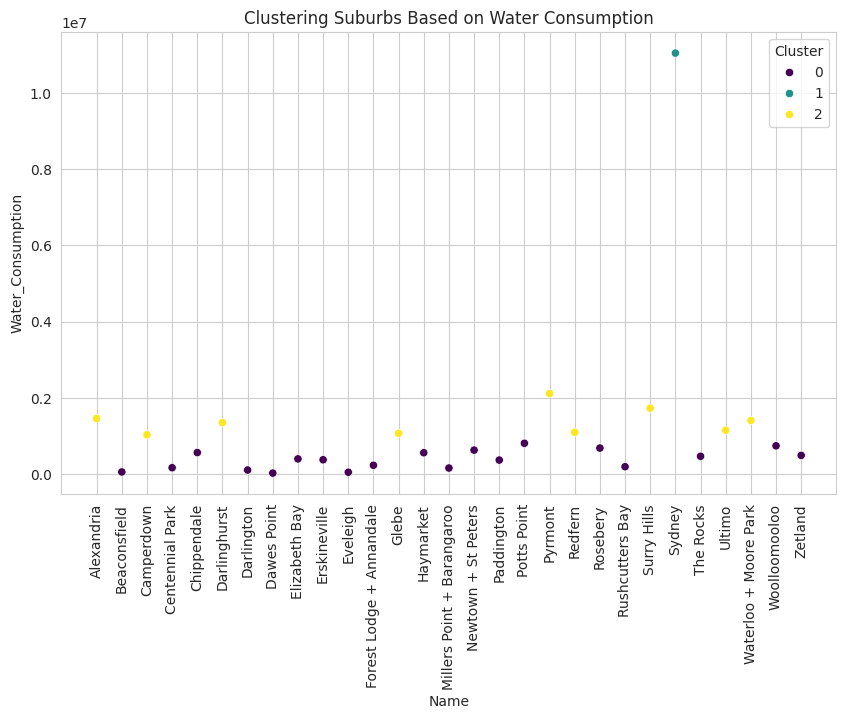

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare data
df_cluster = df_melted.groupby("Name").agg({"Water_Consumption": "mean"}).reset_index()
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster[["Water_Consumption"]])

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster["Cluster"] = kmeans.fit_predict(df_cluster_scaled)

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_cluster["Name"], y=df_cluster["Water_Consumption"], hue=df_cluster["Cluster"], palette="viridis")
plt.xticks(rotation=90)
plt.title("Clustering Suburbs Based on Water Consumption")
plt.show()


In [10]:
!pip install tensorflow

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Prepare Data for LSTM
df_forecast = df_melted.groupby(["Year", "Name"], as_index=False)["Water_Consumption"].mean()
df_forecast = df_forecast.pivot(index="Year", columns="Name", values="Water_Consumption").fillna(method="ffill")

# Normalize Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_forecast)

# Create Sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5  # Using past 5 years to predict next year
X, y = create_sequences(df_scaled, seq_length)

# Build LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, df_scaled.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dense(df_scaled.shape[1])  # Output for each suburb
])

model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=50, batch_size=8, verbose=1)

<ipython-input-11-8ded90ae9257>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_forecast = df_forecast.pivot(index="Year", columns="Name", values="Water_Consumption").fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.3673
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.3333 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.3139
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2834 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2490 
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.2296
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2031
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1867
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1601 
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1475 
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1318
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1167 
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1047
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1008
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0926
Epoch 16/50
2/2 ━━━━━━━━━━

In [17]:
# Save Trained Model
model.save("/content/drive/Othercomputers/My Laptop/Water Usage Pattern/models/water_lstm_model.h5")
print("Model saved successfully to models/water_lstm_model.h5")

Model saved successfully to models/water_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


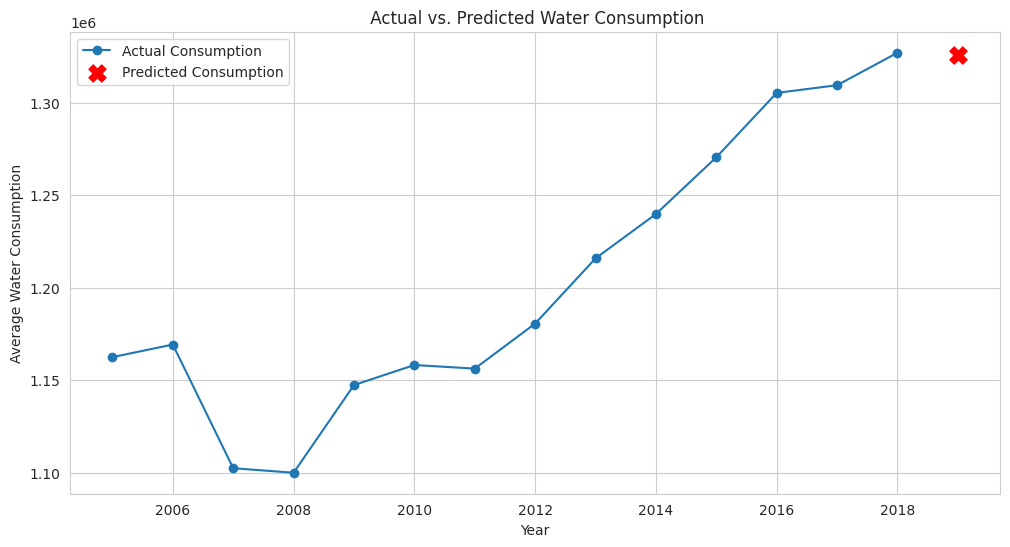

In [12]:
# Predict Next Year
future_input = X[-1].reshape(1, seq_length, df_scaled.shape[1])
future_prediction = model.predict(future_input)

# Convert predictions back to original scale
future_prediction = scaler.inverse_transform(future_prediction)

# Prepare for plotting
last_year = df_forecast.index[-1]  # Get last available year in dataset
future_years = [last_year + i for i in range(1, 2)]  # Predict next year only

# Plot Actual vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(df_forecast.index, df_forecast.mean(axis=1), label="Actual Consumption", marker="o", linestyle="-")
plt.scatter(future_years, future_prediction.mean(axis=1), color="red", label="Predicted Consumption", marker="X", s=150)
plt.xlabel("Year")
plt.ylabel("Average Water Consumption")
plt.title(" Actual vs. Predicted Water Consumption")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Print Predicted Values Clearly
predicted_df = pd.DataFrame(future_prediction, columns=df_forecast.columns, index=future_years)
print("\n Predicted Water Consumption for Next Year:")
print(predicted_df.T.sort_values(by=future_years[0], ascending=False).head(10))  # Show top 10 suburbs


 Predicted Water Consumption for Next Year:
                             2019.0
Name                               
Sydney                 1.252645e+07
Pyrmont                2.792215e+06
Surry Hills            2.072045e+06
Waterloo + Moore Park  1.953527e+06
Alexandria             1.928097e+06
Darlinghurst           1.528687e+06
Camperdown             1.457502e+06
Ultimo                 1.407854e+06
Redfern                1.277332e+06
Glebe                  1.225908e+06


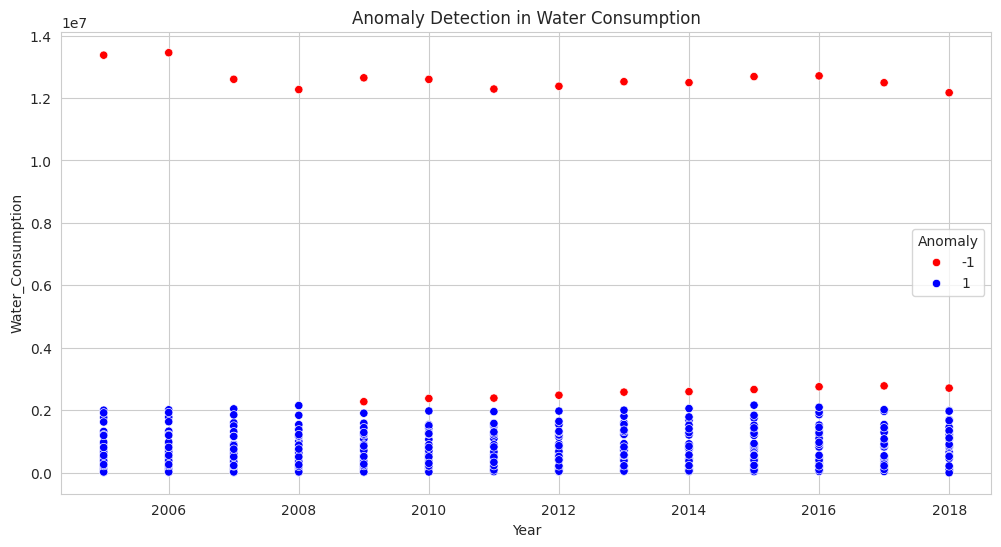

In [14]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_melted["Anomaly"] = iso_forest.fit_predict(df_melted[["Water_Consumption"]])

# Identify anomalies
anomalies = df_melted[df_melted["Anomaly"] == -1]

# Plot anomalies
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_melted, x="Year", y="Water_Consumption", hue=df_melted["Anomaly"], palette={-1: "red", 1: "blue"})
plt.title("Anomaly Detection in Water Consumption")
plt.show()


In [15]:
!pip install folium
!pip install geopandas

In [16]:
import geopandas as gpd
import pandas as pd
import folium

# Load GeoJSON file (Suburb Boundaries)
geo_df = gpd.read_file("/content/drive/Othercomputers/My Laptop/Water Usage Pattern/data/Potable_water_consumption_by_suburb.geojson")

# Load Water Consumption Data
water_df = pd.read_csv("/content/drive/Othercomputers/My Laptop/Water Usage Pattern/data/Potable_water_consumption_by_suburb_2018-2024.csv")

# Extract suburb names and yearly water consumption
water_cols = [col for col in water_df.columns if "F" in col]  # Select fiscal year columns
water_df["Average_Consumption"] = water_df[water_cols].mean(axis=1)  # Compute average usage

# Keep only relevant columns
water_df = water_df[["Name", "Average_Consumption"]]

# Ensure column names match for merging
geo_df = geo_df.rename(columns={"suburb_name": "Name"})  # Standardize naming

# Merge GIS and Water Consumption Data
merged_df = geo_df.merge(water_df, on="Name", how="left")

# Create Folium Map (Centered on Perth, Australia)
m = folium.Map(location=[-31.9505, 115.8605], zoom_start=10)

# Add Choropleth Layer
folium.Choropleth(
    geo_data=merged_df,
    name="Water Consumption",
    data=merged_df,
    columns=["Name", "Average_Consumption"],
    key_on="feature.properties.Name",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Avg Water Consumption (ML)"
).add_to(m)

# Add Suburb Labels
for _, row in merged_df.iterrows():
    if pd.notna(row["Average_Consumption"]):  # Only label suburbs with data
        folium.Marker(
            location=[row.geometry.centroid.y, row.geometry.centroid.x],
            popup=f"{row['Name']}: {row['Average_Consumption']:.2f} ML",
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(m)

# Save and Display the Map
map_filename = "/content/drive/Othercomputers/My Laptop/Water Usage Pattern/visualizations/water_usage_map.html"
m.save(map_filename)
print(f"Interactive map saved: {map_filename}")


Interactive map saved: /content/drive/Othercomputers/My Laptop/Water Usage Pattern/visualizations/water_usage_map.html
